[*********************100%***********************]  1 of 1 completed

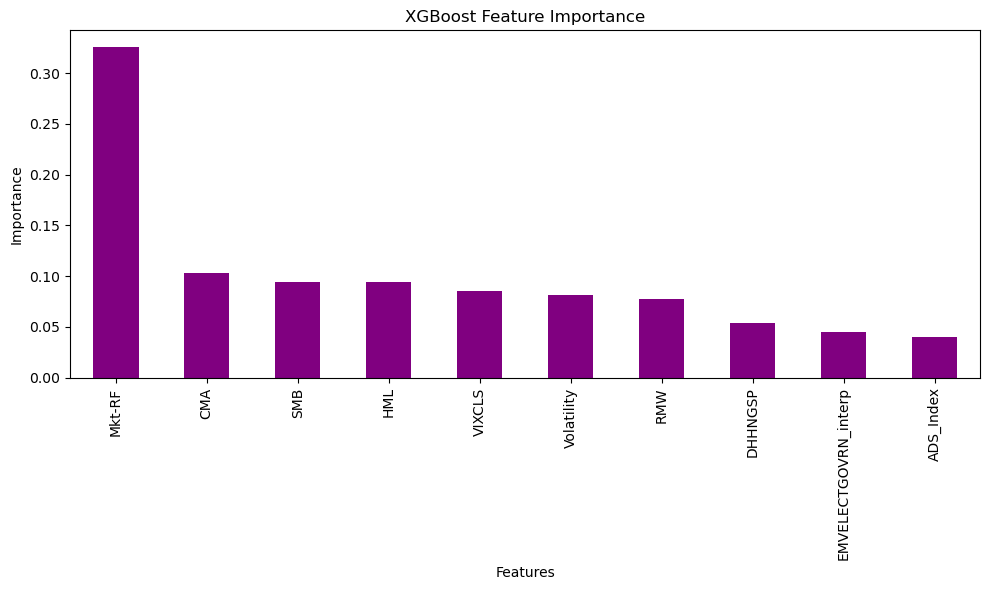

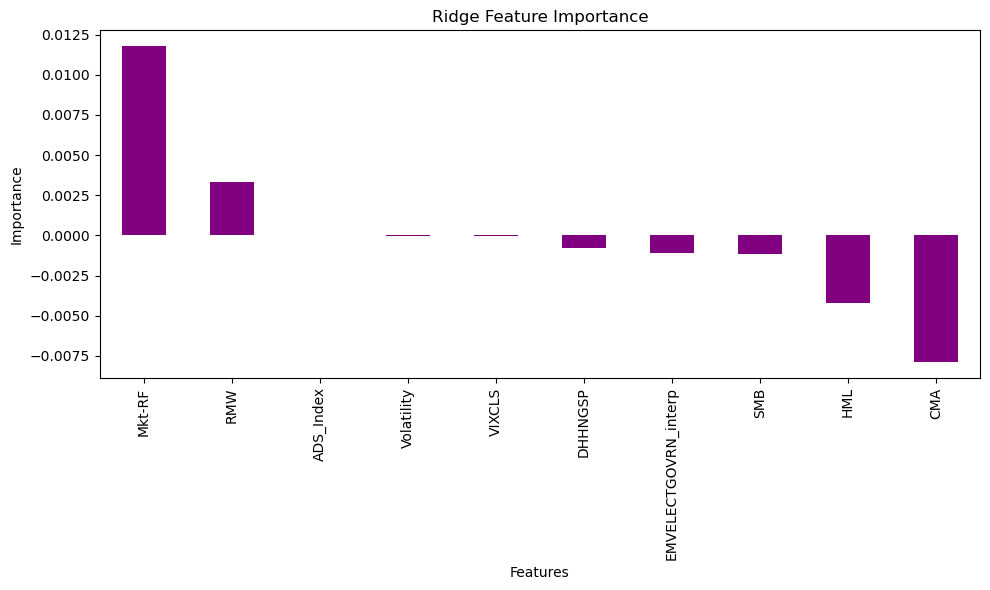

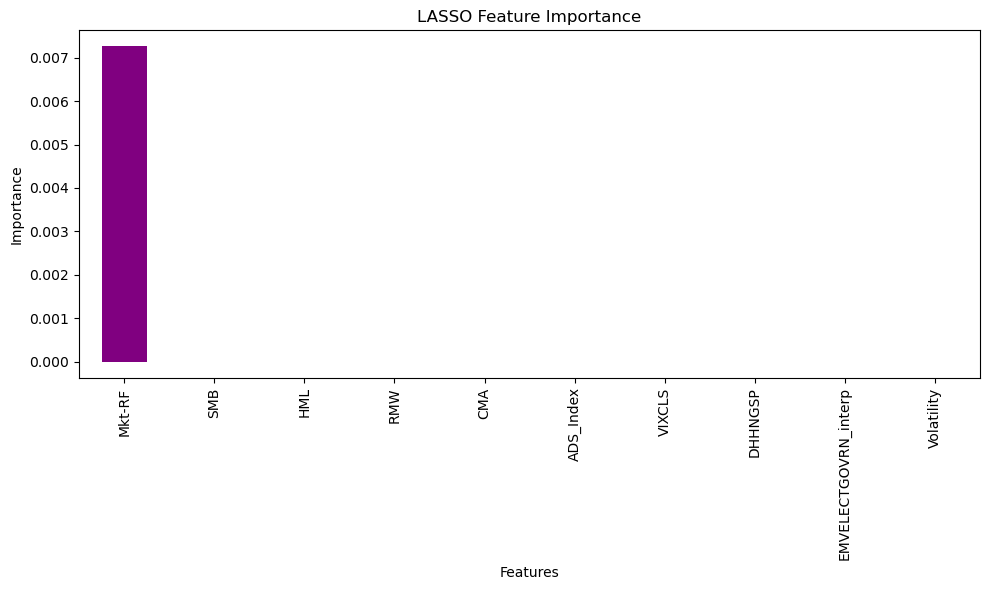

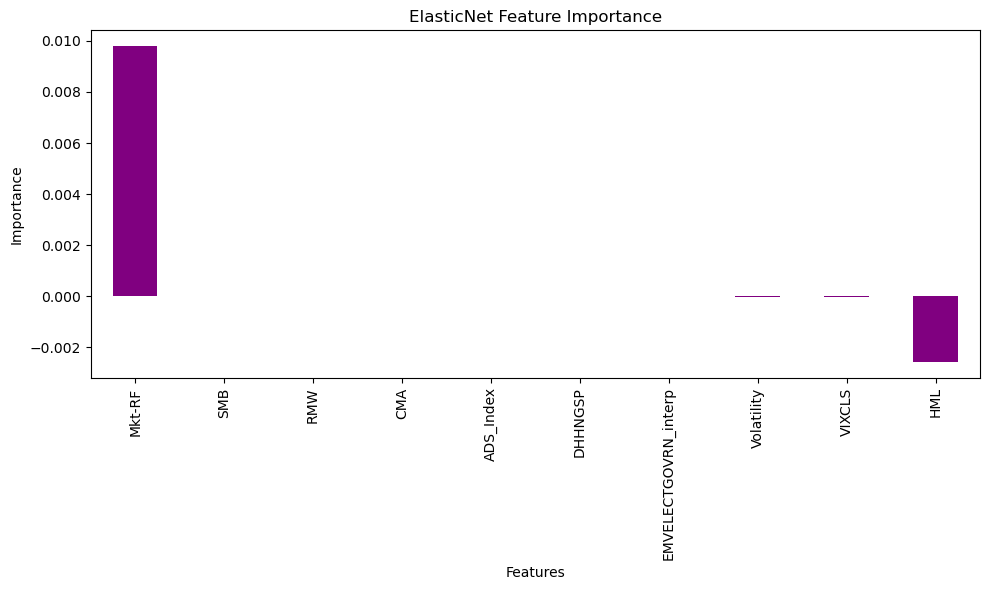

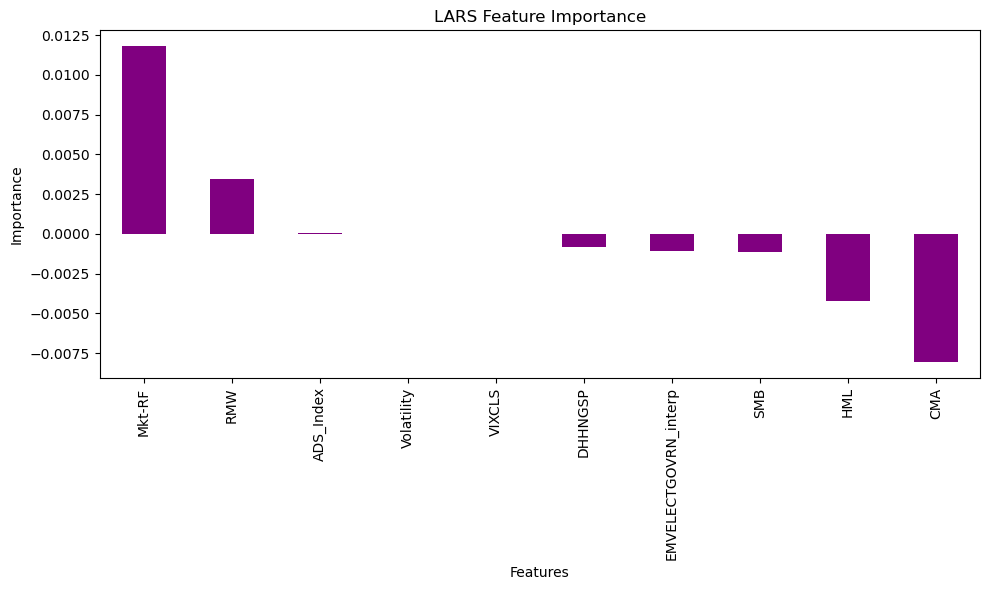

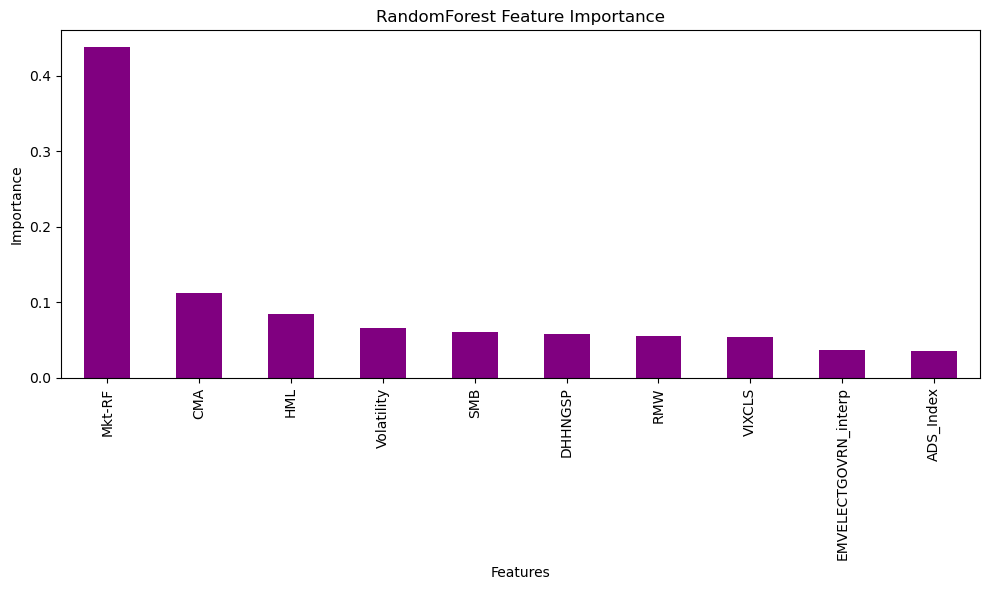

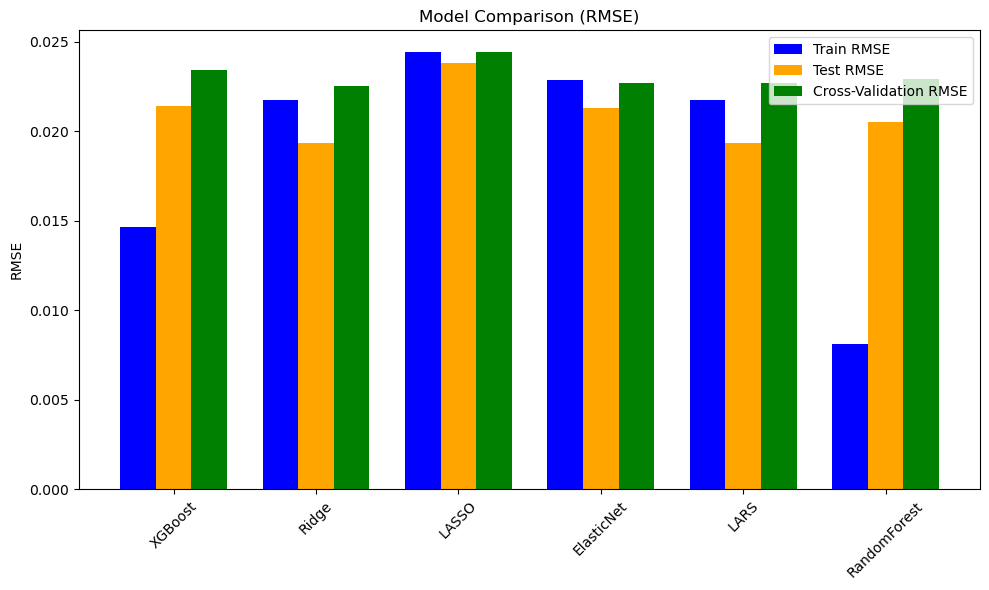

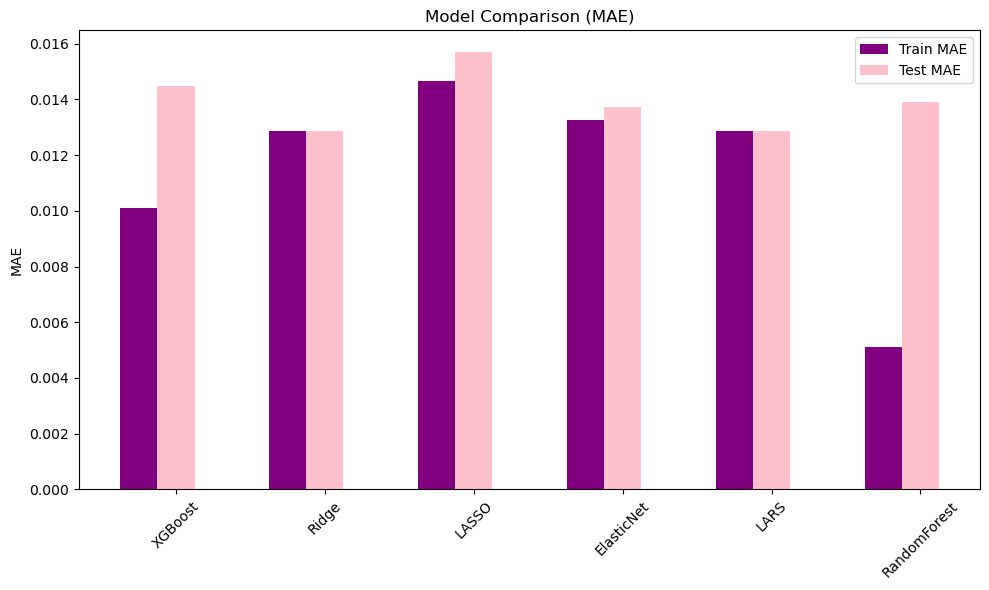

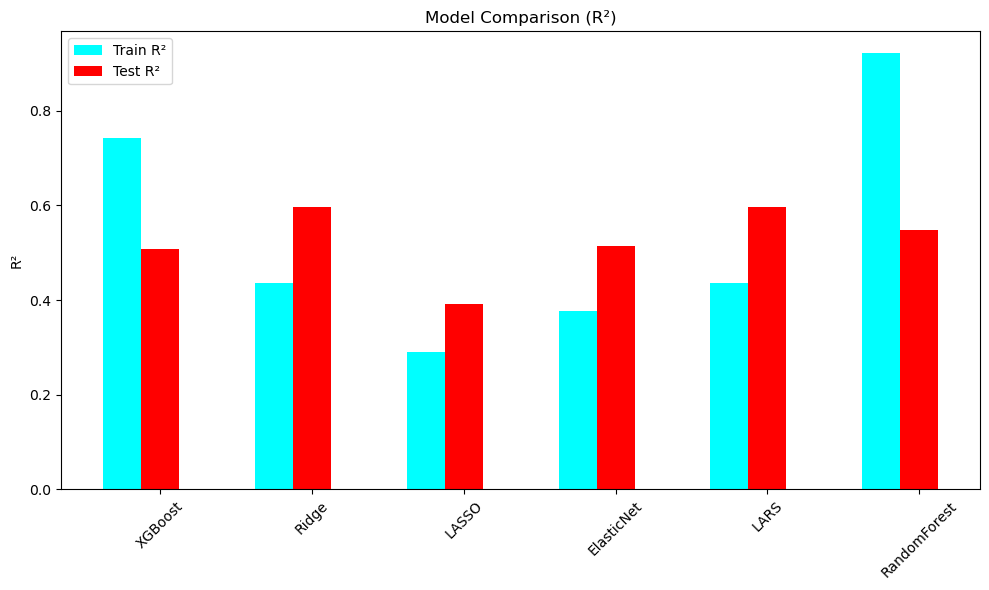


Summary Table:
          Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  \
0       XGBoost    0.014682   0.021432   0.010105  0.014487  0.743218   
1         Ridge    0.021757   0.019372   0.012849  0.012847  0.436114   
2         LASSO    0.024421   0.023810   0.014652  0.015692  0.289554   
3    ElasticNet    0.022868   0.021296   0.013269  0.013741  0.377037   
4          LARS    0.021757   0.019370   0.012857  0.012854  0.436126   
5  RandomForest    0.008106   0.020549   0.005119  0.013892  0.921731   

    Test R²  Cross-Validation RMSE  
0  0.507431               0.023444  
1  0.597584               0.022535  
2  0.392099               0.024430  
3  0.513684               0.022736  
4  0.597660               0.022733  
5  0.547207               0.022943  


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Step 1: Download Meta stock data
meta_data = yf.download("META", start="2020-01-01", end="2024-08-30", interval="1d")
meta_data.reset_index(inplace=True)
meta_data["Log Return"] = np.log(meta_data["Close"] / meta_data["Close"].shift(1))
meta_data = meta_data.dropna()
meta_data = meta_data[["Date", "Log Return"]]

# Step 2: Load and merge the dataset
file_path = (
    "C:/Users/aqeel/work/NEU/DS INFO6105/final_dashboard/data/3.csv"  # Update this path
)
data = pd.read_csv(file_path)
data["Date"] = pd.to_datetime(data["Date"])
meta_data["Date"] = pd.to_datetime(meta_data["Date"])

# Flatten the multi-level columns in meta_data
meta_data.columns = [
    col[0] if col[1] == "" else f"{col[0]}_{col[1]}" for col in meta_data.columns
]

merged_data = pd.merge(data, meta_data, on="Date", how="inner")
merged_data.fillna(merged_data.mean(), inplace=True)

# Step 3: Data Cleaning
X = merged_data.drop(columns=["Date", "Log Return"])
y = merged_data["Log Return"]

# Remove high VIF features
X_vif = add_constant(X)
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
high_vif_features = vif[vif["VIF"] > 10]["Feature"].tolist()
X = X.drop(columns=high_vif_features, errors="ignore")

# Remove low variance features
low_variance_features = X.columns[X.var() < 0.01].tolist()
X = X.drop(columns=low_variance_features, errors="ignore")

# Remove highly correlated features
corr_matrix = X.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr_features = [
    column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)
]
X = X.drop(columns=high_corr_features, errors="ignore")

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 5: Define Models
models = {
    "XGBoost": xgb.XGBRegressor(
        learning_rate=0.05, max_depth=3, n_estimators=200, random_state=42
    ),
    "Ridge": Ridge(alpha=5),
    "LASSO": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "LARS": Lars(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
}

# Step 6: Train and Evaluate Models
results = []
feature_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    cv_scores = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
    cv_rmse = np.sqrt(cv_scores.mean())

    results.append(
        (name, train_rmse, test_rmse, train_mae, test_mae, train_r2, test_r2, cv_rmse)
    )

    # Feature importance
    if hasattr(model, "coef_"):
        feature_importances[name] = pd.Series(model.coef_, index=X.columns).sort_values(
            ascending=False
        )
    elif hasattr(model, "feature_importances_"):
        feature_importances[name] = pd.Series(
            model.feature_importances_, index=X.columns
        ).sort_values(ascending=False)

# Step 7: Results and Visualizations
result_df = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Train RMSE",
        "Test RMSE",
        "Train MAE",
        "Test MAE",
        "Train R²",
        "Test R²",
        "Cross-Validation RMSE",
    ],
)

# 1. Feature Importance Graphs
for name, importance in feature_importances.items():
    plt.figure(figsize=(10, 6))
    importance.plot(kind="bar", color="purple")
    plt.title(f"{name} Feature Importance")
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.tight_layout()
    plt.show()

# 2. Model Comparison Graphs
plt.figure(figsize=(10, 6))
width = 0.25
x = np.arange(len(result_df["Model"]))
plt.bar(
    x - width, result_df["Train RMSE"], width=width, label="Train RMSE", color="blue"
)
plt.bar(x, result_df["Test RMSE"], width=width, label="Test RMSE", color="orange")
plt.bar(
    x + width,
    result_df["Cross-Validation RMSE"],
    width=width,
    label="Cross-Validation RMSE",
    color="green",
)
plt.xticks(x, result_df["Model"], rotation=45)
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(
    x - width, result_df["Train MAE"], width=width, label="Train MAE", color="purple"
)
plt.bar(x, result_df["Test MAE"], width=width, label="Test MAE", color="pink")
plt.xticks(x, result_df["Model"], rotation=45)
plt.title("Model Comparison (MAE)")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x - width, result_df["Train R²"], width=width, label="Train R²", color="cyan")
plt.bar(x, result_df["Test R²"], width=width, label="Test R²", color="red")
plt.xticks(x, result_df["Model"], rotation=45)
plt.title("Model Comparison (R²)")
plt.ylabel("R²")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Summary Table
print("\nSummary Table:")
print(result_df)


[*********************100%***********************]  1 of 1 completed


XGBoost - Train RMSE: 0.014681952074718757, Test RMSE: 0.021432334531479125, Train R²: 0.7432177114745167, Test R²: 0.5074306642972698


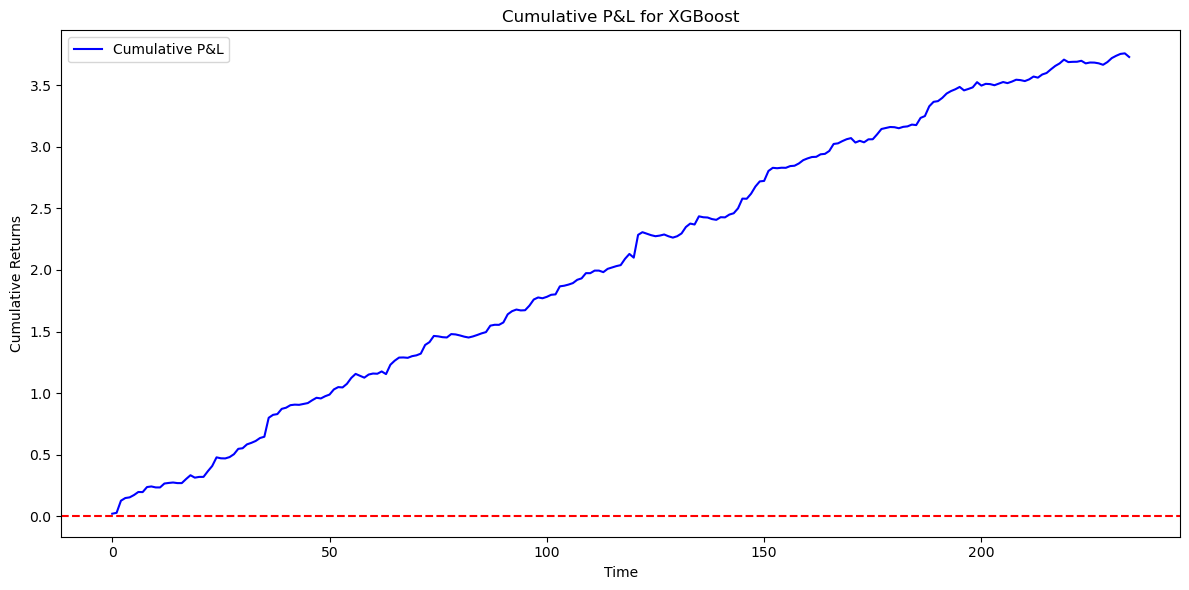

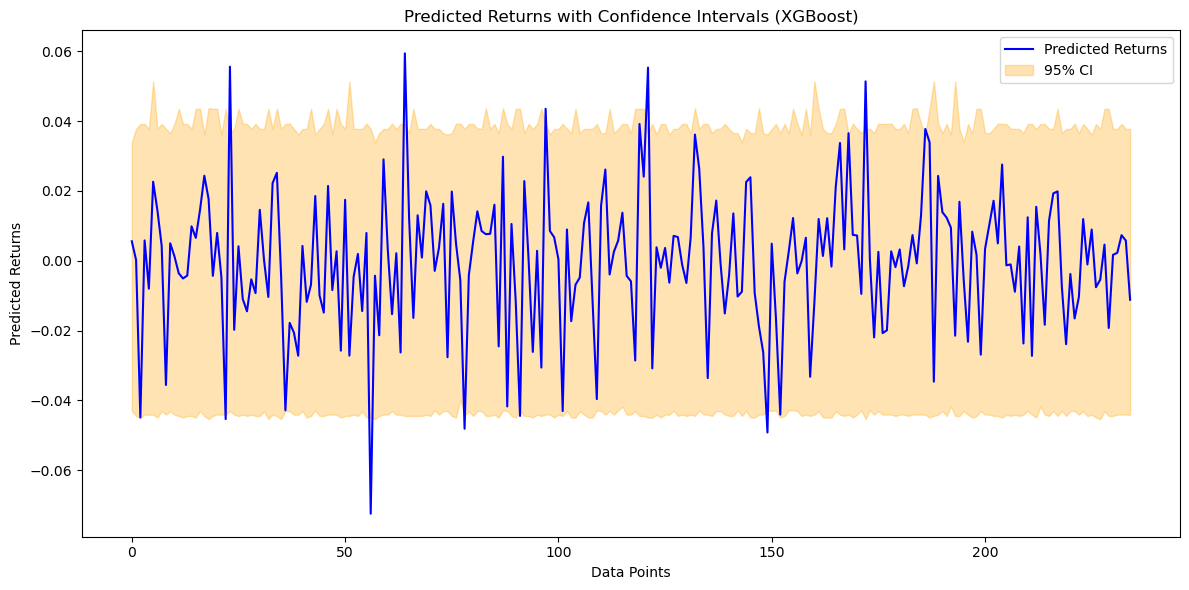

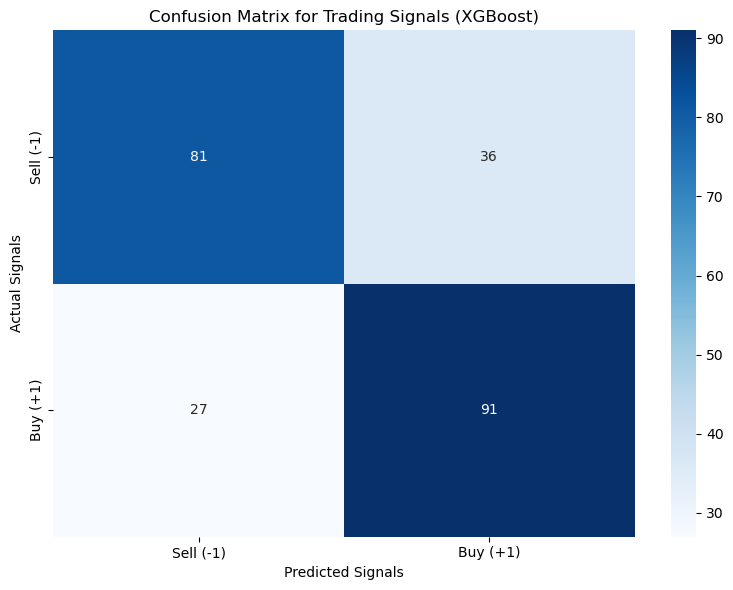


Classification Report for Trading Signals (XGBoost):
              precision    recall  f1-score   support

   Sell (-1)       0.75      0.69      0.72       117
    Buy (+1)       0.72      0.77      0.74       118

    accuracy                           0.73       235
   macro avg       0.73      0.73      0.73       235
weighted avg       0.73      0.73      0.73       235


Summary Statistics:
       Metric     Value
0  Train RMSE  0.014682
1   Test RMSE  0.021432
2    Train R²  0.743218
3     Test R²  0.507431


In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
    classification_report,
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import Lars
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Step 1: Download Meta stock data
meta_data = yf.download("META", start="2020-01-01", end="2024-08-30", interval="1d")
meta_data.reset_index(inplace=True)
meta_data["Log Return"] = np.log(meta_data["Close"] / meta_data["Close"].shift(1))
meta_data = meta_data.dropna()
meta_data = meta_data[["Date", "Log Return"]]

# Step 2: Load and merge the dataset
file_path = (
    "C:/Users/aqeel/work/NEU/DS INFO6105/final_dashboard/data/3.csv"  # Update this path
)
data = pd.read_csv(file_path)
data["Date"] = pd.to_datetime(data["Date"])
meta_data["Date"] = pd.to_datetime(meta_data["Date"])

# Flatten the multi-level columns in meta_data
meta_data.columns = [
    col[0] if col[1] == "" else f"{col[0]}_{col[1]}" for col in meta_data.columns
]

merged_data = pd.merge(data, meta_data, on="Date", how="inner")
merged_data.fillna(merged_data.mean(), inplace=True)

# Step 3: Data Cleaning
X = merged_data.drop(columns=["Date", "Log Return"])
y = merged_data["Log Return"]

# Remove high VIF features
X_vif = add_constant(X)
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
high_vif_features = vif[vif["VIF"] > 10]["Feature"].tolist()
X = X.drop(columns=high_vif_features, errors="ignore")

# Remove low variance features
low_variance_features = X.columns[X.var() < 0.01].tolist()
X = X.drop(columns=low_variance_features, errors="ignore")

# Remove highly correlated features
corr_matrix = X.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr_features = [
    column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)
]
X = X.drop(columns=high_corr_features, errors="ignore")

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 5: Define Models
xgboost_model = xgb.XGBRegressor(
    learning_rate=0.05, max_depth=3, n_estimators=200, random_state=42
)
xgboost_model.fit(X_train, y_train)

# Predictions
train_preds = xgboost_model.predict(X_train)
test_preds = xgboost_model.predict(X_test)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
print(
    f"XGBoost - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}, Train R²: {train_r2}, Test R²: {test_r2}"
)

# Step 6: Additional Visualizations and Analysis for XGBoost
# 1. Cumulative P&L Plot
signals = np.where(
    test_preds > 0, 1, -1
)  # Buy (+1) if positive return, Sell (-1) if negative
cumulative_returns = np.cumsum(signals * y_test.values)
timevec = np.arange(len(cumulative_returns))

plt.figure(figsize=(12, 6))
plt.plot(timevec, cumulative_returns, label="Cumulative P&L", color="blue")
plt.axhline(0, color="red", linestyle="--")
plt.title("Cumulative P&L for XGBoost")
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Confidence Intervals for Predictions
# Bootstrapping for Confidence Intervals
n_bootstraps = 1000
bootstrap_preds = []

for _ in range(n_bootstraps):
    indices = np.random.choice(len(X_test), len(X_test), replace=True)
    X_bootstrap = X_test.iloc[indices]
    bootstrap_preds.append(xgboost_model.predict(X_bootstrap))

bootstrap_preds = np.array(bootstrap_preds)
ci_lower = np.percentile(bootstrap_preds, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_preds, 97.5, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(test_preds, label="Predicted Returns", color="blue")
plt.fill_between(
    range(len(test_preds)),
    ci_lower,
    ci_upper,
    color="orange",
    alpha=0.3,
    label="95% CI",
)
plt.title("Predicted Returns with Confidence Intervals (XGBoost)")
plt.xlabel("Data Points")
plt.ylabel("Predicted Returns")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Trading Signal Accuracy (Confusion Matrix)
threshold = 0.0  # Threshold for positive/negative signal
actual_signals = np.where(
    y_test > threshold, 1, -1
)  # Actual signals: +1 for positive return, -1 for negative
predicted_signals = np.where(
    test_preds > threshold, 1, -1
)  # Predicted signals: +1 for positive return, -1 for negative

cm = confusion_matrix(actual_signals, predicted_signals)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Sell (-1)", "Buy (+1)"],
    yticklabels=["Sell (-1)", "Buy (+1)"],
)
plt.title("Confusion Matrix for Trading Signals (XGBoost)")
plt.xlabel("Predicted Signals")
plt.ylabel("Actual Signals")
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report for Trading Signals (XGBoost):")
print(
    classification_report(
        actual_signals, predicted_signals, target_names=["Sell (-1)", "Buy (+1)"]
    )
)

# Summary Statistics
summary_stats = pd.DataFrame(
    {
        "Metric": ["Train RMSE", "Test RMSE", "Train R²", "Test R²"],
        "Value": [train_rmse, test_rmse, train_r2, test_r2],
    }
)
print("\nSummary Statistics:")
print(summary_stats)
